# Logistic Regression : Classification Algorithm

Content:

a) Problem Definition  
b) Preprocessing (Converting dtypes, Missing value imputation)  
c) Model Building and Predicting `Survival` using Logistic Regression   
d) Evaluating model   
e) Feature Engineering (Generate new columns, Standardization of columns)  
f) Cross-Validation  
g) Improving Logistic Regression Model (Tuning)  
h) Insights from Analysis  

### Problem Definition

Predict whether a passenger survived or not given his/her information like age, sex etc

In [1]:
#imports
import os
from collections import Counter
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer, Normalizer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns

## Pre-Processing

In [2]:
# Read CSV train data file into DataFrame
raw = pd.read_csv("Titanic.csv")
display(raw.sample(5))
print('\nUNIQUE:\n\n', raw.nunique())
print('\nMISSING:\n\n', raw.isna().mean())
print('\nDTYPES:\n\n', raw.dtypes)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
552,553,0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,330979,7.8292,NaN,Q
600,601,1,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27.0000,NaN,S
448,449,1,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
343,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,NaN,S



UNIQUE:

 PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

MISSING:

 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

DTYPES:

 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [3]:
numeric = ['Age', 'Fare', 'SibSp', 'Parch']
cat = ['Survived', 'Pclass', 'Sex', 'Embarked']
to_drop = ['Cabin', 'PassengerId', 'Name', 'Ticket']

data = raw.copy()
data[numeric] = data[numeric].astype(float)
for c in cat:
    data[c] = pd.Categorical(data[c])
data.drop(to_drop, axis=1, inplace=True)

data.dtypes

Survived    category
Pclass      category
Sex         category
Age          float64
SibSp        float64
Parch        float64
Fare         float64
Embarked    category
dtype: object

In [4]:
data.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
795,0,2,male,39.0,0.0,0.0,13.0000,S
568,0,3,male,NaN,0.0,0.0,7.2292,C
874,1,2,female,28.0,1.0,0.0,24.0000,C
168,0,1,male,NaN,0.0,0.0,25.9250,S
220,1,3,male,16.0,0.0,0.0,8.0500,S
574,0,3,male,16.0,0.0,0.0,8.0500,S
207,1,3,male,26.0,0.0,0.0,18.7875,C
329,1,1,female,16.0,0.0,1.0,57.9792,C
754,1,2,female,48.0,1.0,2.0,65.0000,S
177,0,1,female,50.0,0.0,0.0,28.7125,C


### Missing value Inspection

Percent of missing "Age" records is 19.87 %


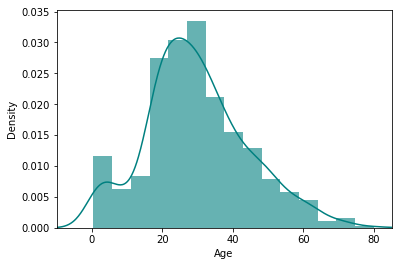

The mean of "Age" is 29.70
The median of "Age" is 28.00
Percent of missing "Embarked" records is 0.22 %
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [5]:
# percent of missing "Age" 
print('Percent of missing "Age" records is {:.2f} %'.format((data.Age.isna().mean())*100))

ax = data["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
data["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

# mean age
print('The mean of "Age" is %.2f' %(data["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(data["Age"].median(skipna=True)))

print('='*66)
print('Percent of missing "Embarked" records is {:.2f} %'.format((data.Embarked.isna().mean())*100))
print(data["Embarked"].value_counts())

### Missing Value Imputation

Let us make the following changes to the data:

a) "Age" can be imputed with median as the distribution is skewed i.e., 28 (median age).  
b) "Embarked" can be imputed with most frequent class "S" (the most common boarding port).  

In [6]:
# check missing values in adjusted train data
proc_data = data.copy()
proc_data["Age"].fillna(data["Age"].median(skipna=True), inplace=True)
proc_data["Embarked"].fillna(data['Embarked'].value_counts().idxmax(), inplace=True)
proc_data.isnull().mean()

Survived    0.0
Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64

(-10, 85)

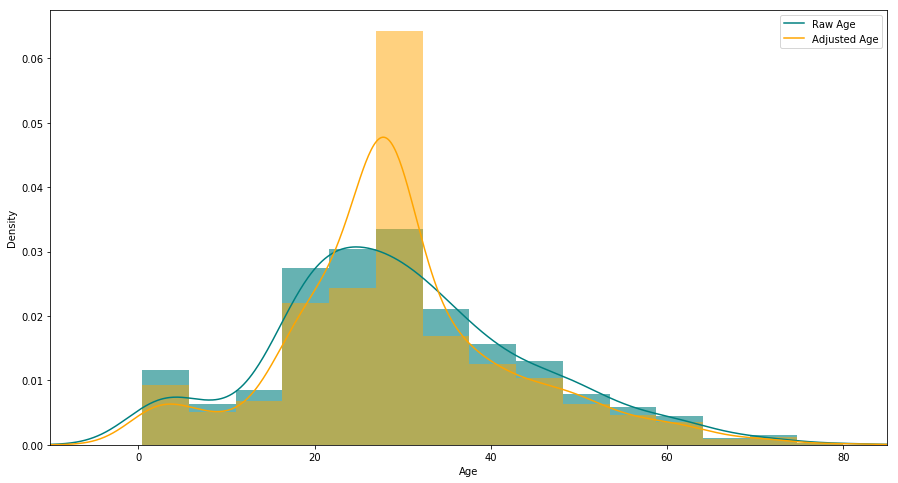

In [7]:
plt.figure(figsize=(15,8))
ax = data["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
data["Age"].plot(kind='density', color='teal')
ax = proc_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
proc_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)

In [8]:
data1 = pd.get_dummies(proc_data, columns=["Pclass","Embarked","Sex"])
data1.drop('Sex_female', axis=1, inplace=True)
data1.drop('Embarked_C', axis=1, inplace=True)
data1.drop('Pclass_3', axis=1, inplace=True)

data1.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,1.0,0.0,7.2500,0,0,0,1,1
1,1,38.0,1.0,0.0,71.2833,1,0,0,0,0
2,1,26.0,0.0,0.0,7.9250,0,0,0,1,0
3,1,35.0,1.0,0.0,53.1000,1,0,0,1,0
4,0,35.0,0.0,0.0,8.0500,0,0,0,1,1


## Initial/Baseline Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data1.iloc[:, 1:], 
                                                    proc_data['Survived'], 
                                                    test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

tr_acc = accuracy_score(lg.predict(X_train), y_train)
te_acc = accuracy_score(y_pred, y_test)

print('Train Accuracy: \t{:.3f} %\nValidation Accuracy: \t{:.3f} %'.format(tr_acc*100, te_acc*100))

(596, 9) (295, 9) (596,) (295,)
Train Accuracy: 	81.711 %
Validation Accuracy: 	80.678 %


/Users/yreddy31/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Feature Engineering

According to the data dictionary, both SibSp and Parch relate to traveling with family. To avoid multicollinearity, let us combine these variables into one categorical predictor: Whether or not that individual was traveling alone.

In [10]:
## Create categorical variable for traveling alone
data2 = data1.copy()
data2['TravelAlone'] = np.where((data2["SibSp"] + data2["Parch"])>0, 0, 1)
data2.drop('SibSp', axis=1, inplace=True)
data2.drop('Parch', axis=1, inplace=True)

### Age distribution amongst survivers

/Users/yreddy31/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


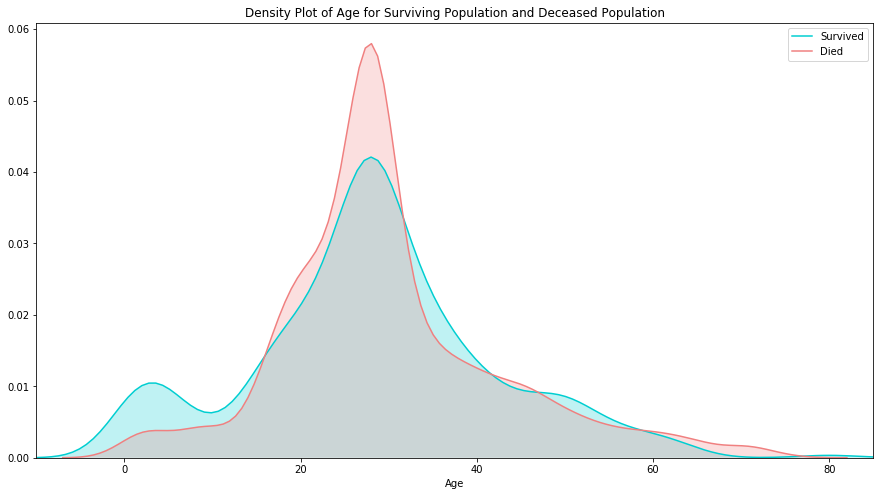

In [11]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(data2["Age"][data2.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(data2["Age"][data2.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Seems that most of the survivers have less age from above plot

Considering the survival rate of passengers under 16, let us include another categorical variable in dataset: "Minor"

In [12]:
data2['IsMinor']=np.where(data2['Age']<=16, 1, 0)

### Ticket Fare distribution

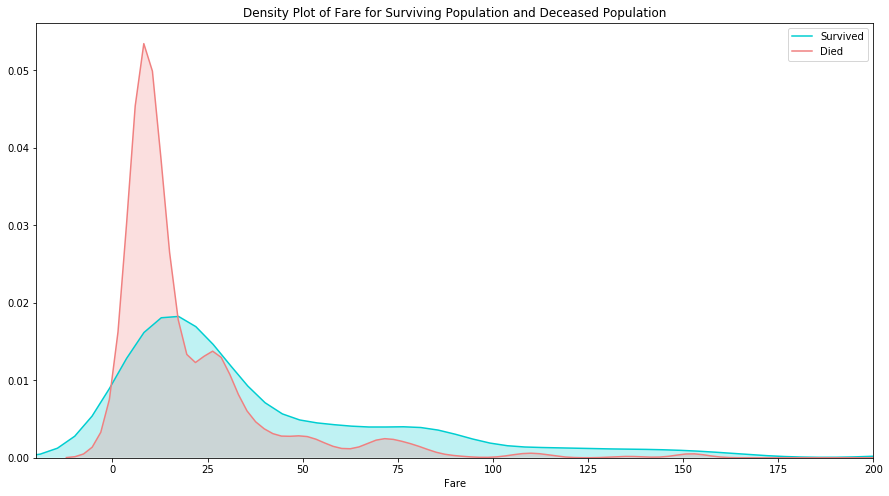

In [13]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(data2["Fare"][data2.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(data2["Fare"][data2.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

As the distributions are clearly different for the fares of survivors vs. deceased, it is likely that this would be a significant predictor in our final model. Passengers who paid lower fare appear to have been less likely to survive. This is probably strongly correlated with Passenger Class, which we'll look at next.

In [14]:
data2['FareBracket'] = pd.Categorical(pd.cut(data2['Fare'], bins=[0, 20, 50, 1000]))
data2 = pd.get_dummies(data2, columns=["FareBracket"], drop_first=True)
display(data2.sample(10))
# data2.columns
data2.sample(10)

,Survived,Age,Fare,Pclass_1,Pclass_2,Embarked_Q,Embarked_S,Sex_male,TravelAlone,IsMinor,"FareBracket_(20, 50]","FareBracket_(50, 1000]"
187,1,45.0,26.5500,1,0,0,1,1,1,0,1,0
595,0,36.0,24.1500,0,0,0,1,1,0,0,1,0
695,0,52.0,13.5000,0,1,0,1,1,1,0,0,0
785,0,25.0,7.2500,0,0,0,1,1,1,0,0,0
257,1,30.0,86.5000,1,0,0,1,0,1,0,0,1
585,1,18.0,79.6500,1,0,0,1,0,0,0,0,1
591,1,52.0,78.2667,1,0,0,0,0,0,0,0,1
496,1,54.0,78.2667,1,0,0,0,0,0,0,0,1
536,0,45.0,26.5500,1,0,0,1,1,1,0,1,0
419,0,10.0,24.1500,0,0,0,1,0,0,1,1,0


,Survived,Age,Fare,Pclass_1,Pclass_2,Embarked_Q,Embarked_S,Sex_male,TravelAlone,IsMinor,"FareBracket_(20, 50]","FareBracket_(50, 1000]"
335,0,28.0,7.8958,0,0,0,1,1,1,0,0,0
790,0,28.0,7.7500,0,0,1,0,1,1,0,0,0
228,0,18.0,13.0000,0,1,0,1,1,1,0,0,0
312,0,26.0,26.0000,0,1,0,1,0,0,0,1,0
593,0,28.0,7.7500,0,0,1,0,0,0,0,0,0
880,1,25.0,26.0000,0,1,0,1,0,0,0,1,0
54,0,65.0,61.9792,1,0,0,0,1,0,0,0,1
315,1,26.0,7.8542,0,0,0,1,0,1,0,0,0
80,0,22.0,9.0000,0,0,0,1,1,1,0,0,0
614,0,35.0,8.0500,0,0,0,1,1,1,0,0,0


### Correlation plot

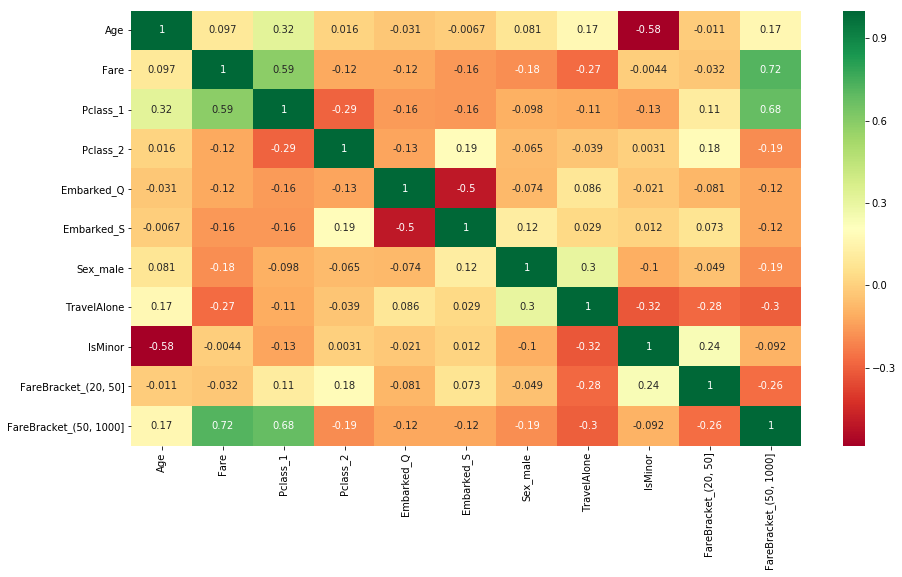

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(data2.corr(), annot=True, cmap="RdYlGn")

In [16]:
# Create correlation matrix
corr_matrix = data2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

to_drop

[]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:, 1:], 
                                                    np.array(data2['Survived']), 
                                                    test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lg = LogisticRegression(solver='lbfgs')
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

tr_acc = accuracy_score(lg.predict(X_train), y_train)
te_acc = accuracy_score(y_pred, y_test)

print('Train Accuracy: \t{:.3f} %\nValidation Accuracy: \t{:.3f} %'.format(tr_acc*100, te_acc*100))

(596, 11) (295, 11) (596,) (295,)
Train Accuracy: 	80.201 %
Validation Accuracy: 	81.017 %


/Users/yreddy31/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Standardization

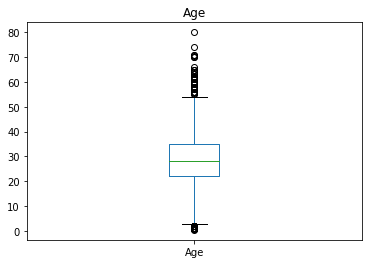

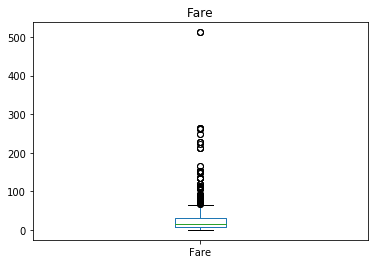

In [18]:
for col in ['Age', 'Fare']:
    display(data2[col].plot(kind = 'box', title=col))
    plt.show()

In [19]:
pt = PowerTransformer(method = 'yeo-johnson', standardize=True)
X_train['Age'] = pt.fit_transform(X_train[['Age']].values)
X_test['Age'] = pt.transform(X_test[['Age']].values)

X_train['Fare'] = pt.fit_transform(X_train[['Fare']].values)
X_test['Fare'] = pt.transform(X_test[['Fare']].values)

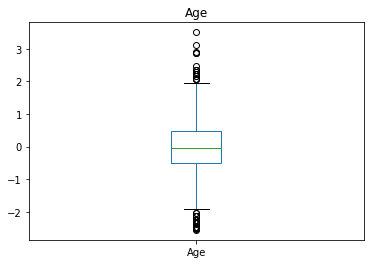

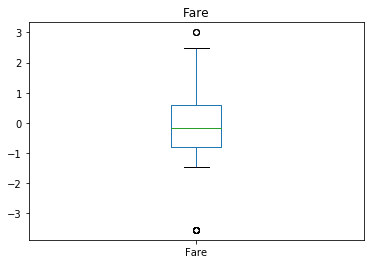

In [20]:
for col in ['Age', 'Fare']:
    display(X_train[col].plot(kind = 'box', title=col))
    plt.show()

In [21]:
lg = LogisticRegression(solver='lbfgs')
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

tr_acc = accuracy_score(lg.predict(X_train), y_train)
te_acc = accuracy_score(y_pred, y_test)

print('Train Accuracy: \t{:.3f} %\nValidation Accuracy: \t{:.3f} %'.format(tr_acc*100, te_acc*100))

Train Accuracy: 	81.376 %
Validation Accuracy: 	81.017 %


In [22]:
X_train.sample(10)

,Age,Fare,Pclass_1,Pclass_2,Embarked_Q,Embarked_S,Sex_male,TravelAlone,IsMinor,"FareBracket_(20, 50]","FareBracket_(50, 1000]"
639,-0.048080,-0.077477,0,0,0,1,1,0,0,0,0
154,-0.048080,-0.871782,0,0,0,1,1,1,0,0,0
4,0.476888,-0.775278,0,0,0,1,1,1,0,0,0
672,2.870815,-0.507504,0,1,0,1,1,1,0,0,0
576,0.403187,-0.292228,0,1,0,1,0,1,0,0,0
632,0.254554,0.553339,1,0,0,0,1,1,0,1,0
35,0.982450,1.062047,1,0,0,1,1,0,0,0,1
567,0.028292,0.190741,0,0,0,1,0,0,0,1,0
656,-0.048080,-0.794724,0,0,0,1,1,1,0,0,0
308,0.104176,0.319058,0,1,0,0,1,0,0,1,0


## Cross-Validation

0.7945112781954886

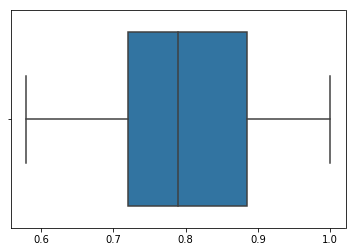

In [23]:
scores = cross_val_score(lg, X_train, y_train.astype(int), cv=30)
sns.boxplot(scores)
scores.mean()

## Improving Model Accuracy (Tuning)

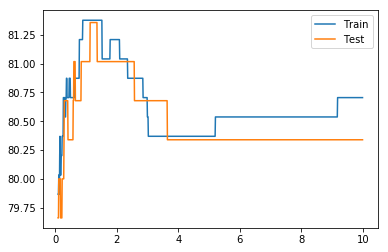

In [24]:
results = []

Cs = np.arange(0.1, 10, 0.01)
for C in Cs:
    lg = LogisticRegression(solver='lbfgs', C=C)
    lg.fit(X_train, y_train)
    y_pred = lg.predict(X_test)

    tr_acc = accuracy_score(lg.predict(X_train), y_train) * 100
    te_acc = accuracy_score(y_pred, y_test) * 100

    results.append((tr_acc, te_acc))
    
results = np.array(results)
sns.lineplot(Cs, results[:,0], label='Train')
sns.lineplot(Cs, results[:,1], label='Test')

In [25]:
best_C = sorted(list(zip(Cs, results[:,1])), key=lambda x: x[1], reverse=True)[0][0]
best_lg = LogisticRegression(solver='lbfgs', C=best_C)
best_lg.fit(X_train, y_train)
y_pred = best_lg.predict(X_test)
tr_acc = accuracy_score(best_lg.predict(X_train), y_train)
te_acc = accuracy_score(y_pred, y_test)
print('Train Accuracy: \t{:.3f} %\nValidation Accuracy: \t{:.3f} %'.format(tr_acc*100, te_acc*100))

Train Accuracy: 	81.376 %
Validation Accuracy: 	81.356 %


## Insights

In [26]:
display(pd.DataFrame({'Col': X_train.columns, 'Coeff': best_lg.coef_[0]}))
best_lg.intercept_
# negative coefficient indicates, `presence/increase of this column decreases the survival chance` and vice-versa

,Col,Coeff
0,Age,-0.147927
1,Fare,0.155571
2,Pclass_1,1.516951
3,Pclass_2,1.367793
4,Embarked_Q,-0.226318
5,Embarked_S,-0.802815
6,Sex_male,-2.337868
7,TravelAlone,0.097404
8,IsMinor,0.675516
9,"FareBracket_(20, 50]",-0.584644


array([0.814792])

Text(0.5, 1.0, 'Average drop in Accuracy after shuffling this column')

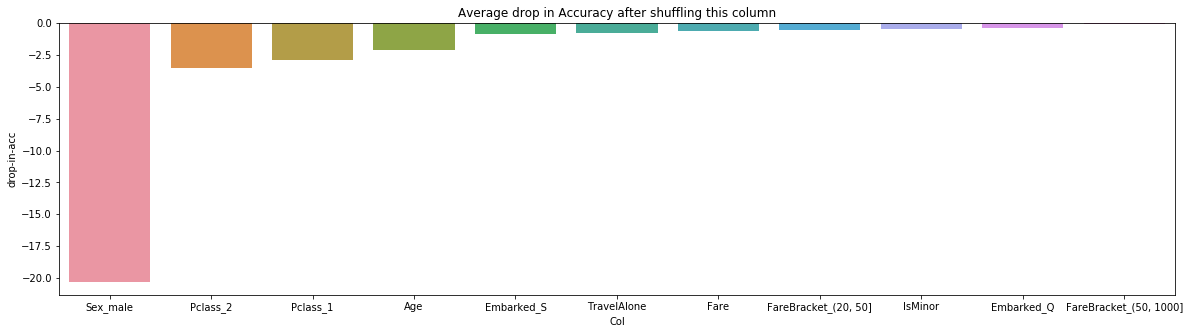

In [27]:
def shuffle_col(col):
    df = X_test.copy()
    column = df[col].values
    np.random.shuffle(column)
    df[col] = column
    return df

y_pred = best_lg.predict(X_test)
base_acc = accuracy_score(y_pred, y_test)
# print('Baseline Validation Accuracy: \t{:.3f} %'.format(base_acc*100))
results = []

for _ in range(100):
    for col in X_test.columns:
        shuff_df = shuffle_col(col)
        y_pred = best_lg.predict(shuff_df)
        te_acc = accuracy_score(y_pred, y_test)
        # print('Validation Accuracy after shuffling `{}`: {:.3f} %'.format(col, te_acc*100))
        results.append((col, (te_acc - base_acc)*100))
    
df = pd.DataFrame(results, columns=['Col', 'drop-in-acc'])
df = df.groupby('Col').aggregate({'drop-in-acc': 'mean'}).reset_index().sort_values('drop-in-acc')
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Col', y='drop-in-acc', data=df, ax=ax); ax.set_title('Average drop in Accuracy after shuffling this column')